<a href="https://colab.research.google.com/github/PristRawal/Machine-Learning/blob/master/Volume_and_VE_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import nibabel as nib
import numpy as np
import os
from glob import glob
import pandas as pd
import csv
import re
import matplotlib as plt

In [ ]:
label_directory='/content/drive/MyDrive/dataset/OASIS3_Dataset_Part4-20240506T062954Z-001/OASIS3_Dataset_Part4/Label_Folder'

In [ ]:
label_files=sorted(glob(f'{label_directory}/**/*.nii.gz*',recursive=True))

In [ ]:
val_data=label_files[118:]

In [ ]:
output_dir = '/content/drive/MyDrive/Segmented_Outputs'
csv_output_dir = '/content/drive/MyDrive/Volume_file'
os.makedirs(csv_output_dir, exist_ok=True)
csv_output_path = os.path.join(csv_output_dir, 'label_volumes.csv')

segmented_files = [f for f in os.listdir(output_dir) if f.endswith('_segmented.nii.gz')]
volume_data = []

for seg_file in segmented_files:
    seg_img_path = os.path.join(output_dir, seg_file)
    seg_img = nib.load(seg_img_path)
    seg_data = seg_img.get_fdata()

    voxel_dims = seg_img.header.get_zooms()[:3]
    voxel_volume_mm3 = np.prod(voxel_dims)

    unique_labels = np.unique(seg_data)
    label_volumes = {label: np.sum(seg_data == label) * voxel_volume_mm3 for label in unique_labels}

    image_id = extract_id(seg_file)
    row_data = [image_id]

    for label in range(45):
        row_data.append(label_volumes.get(label, 0))

    volume_data.append(row_data)

volume_data.sort(key=lambda x: x[0])
header = ['Id'] + [f'label {i}' for i in range(45)]

with open(csv_output_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(header)
    writer.writerows(volume_data)

print(f"Volume data saved to {csv_output_path}")


Volume data saved to /content/drive/MyDrive/Volume_file/label_volumes.csv


### Volume error calculation

In [ ]:
original_volume_file = "/content/drive/MyDrive/Volume_file/original_label_volume.csv"
segmented_volume_file = "/content/drive/MyDrive/Volume_file/label_volumes.csv"

In [ ]:
original_volumes = pd.read_csv(original_volume_file)
segmented_volumes = pd.read_csv(segmented_volume_file)

original_volumes = original_volumes.sort_values('Id').reset_index(drop=True)
segmented_volumes = segmented_volumes.sort_values('Id').reset_index(drop=True)

volume_errors = np.abs(original_volumes.iloc[:, 1:] - segmented_volumes.iloc[:, 1:])
mean_volume_errors = volume_errors.mean(axis=0)

mean_volume_errors_file = "/content/drive/MyDrive/Volume_file/mean_volume_errors.csv"
mean_volume_errors.to_csv(mean_volume_errors_file, index=True, header=["Mean Volume Error"])

print(f"Mean volume errors for each label have been saved to {mean_volume_errors_file}")


Mean volume errors for each label have been saved to /content/drive/MyDrive/Volume_file/mean_volume_errors.csv


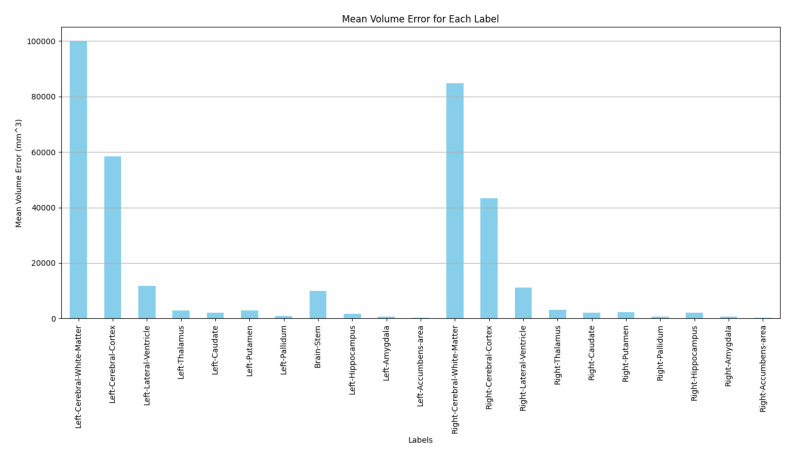

In [ ]:
plt.figure(figsize=(14, 8))
mean_volume_errors.plot(kind='bar', color='skyblue')
plt.title('Mean Volume Error for Each Label')
plt.xlabel('Labels')
plt.ylabel('Mean Volume Error (mm^3)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()